In [5]:
import h5py
import os
data_folder = "/Users/mayankshrivastava/Desktop/DataAssimilation/FlowDAS/experiments/lorenz/data/dataset"
train_dataset = os.path.join(data_folder, 'train.h5')
valid_dataset = os.path.join(data_folder,'valid.h5')
test_dataset = os.path.join(data_folder,'test.h5')

In [10]:
with h5py.File(train_dataset, "r") as f:
    for k in f.keys():
        print(type(k), f[k][0])

<class 'str'> [[-0.57381225 -0.34908766  0.04534056]
 [-0.54571825 -0.41483006 -0.13188073]
 [-0.543374   -0.46738476 -0.25700969]
 ...
 [ 1.4952333   1.7595592   0.14265592]
 [ 1.6085434   1.7430704   0.49547815]
 [ 1.6978848   1.5848696   0.84663785]]


Keys: ['data']


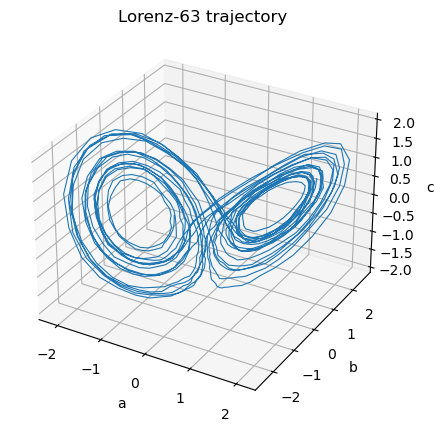

In [11]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Path to dataset
path = "/Users/mayankshrivastava/Desktop/DataAssimilation/FlowDAS/experiments/lorenz/data/dataset/train.h5"

# Load the file
with h5py.File(path, "r") as f:
    print("Keys:", list(f.keys()))
    # Suppose your data key is 'states' (may also be 'x', 'trajectories', etc.)
    trajs = f["data"][:]  # shape (N_traj, T, 3)

# Pick one trajectory to visualize
traj = trajs[0]  # shape (T, 3)
a, b, c = traj[:, 0], traj[:, 1], traj[:, 2]

# 3D phase plot
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.plot(a, b, c, lw=0.8)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("c")
ax.set_title("Lorenz-63 trajectory")
plt.show()


Keys: ['data']


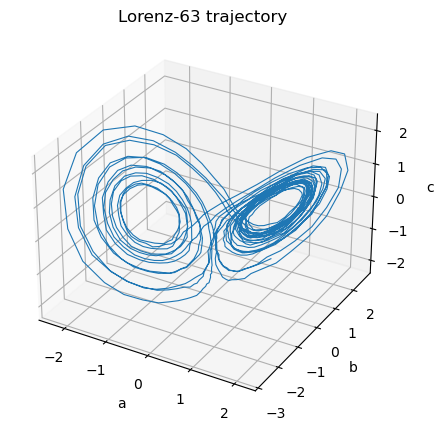

In [13]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Path to dataset
path = "/Users/mayankshrivastava/Desktop/DataAssimilation/FlowDAS/experiments/lorenz/data/dataset/test.h5"

# Load the file
with h5py.File(path, "r") as f:
    print("Keys:", list(f.keys()))
    # Suppose your data key is 'states' (may also be 'x', 'trajectories', etc.)
    trajs = f["data"][:]  # shape (N_traj, T, 3)

# Pick one trajectory to visualize
traj = trajs[0]  # shape (T, 3)
a, b, c = traj[:, 0], traj[:, 1], traj[:, 2]

# 3D phase plot
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")
ax.plot(a, b, c, lw=0.8)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("c")
ax.set_title("Lorenz-63 trajectory")
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

In [ ]:
import h5py, math, torch, torch.nn as nn
import matplotlib.pyplot as plt
from typing import Literal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# 0) Load validation set
# -----------------------
val_path = "/Users/mayankshrivastava/Desktop/DataAssimilation/FlowDAS/experiments/lorenz/data/dataset/valid.h5"
with h5py.File(val_path, "r") as f:
    print("Val keys:", list(f.keys()))
    X_val = f["data"][:]          # shape [N_val, T, 3] (change key if needed)

X_val = torch.from_numpy(X_val).float().to(device)
N_val, T, D = X_val.shape

# -----------------------
# 1) Observation operator
# -----------------------
def obs_operator(x: torch.Tensor, mode: Literal["arctan","linear"]="arctan"):
    """
    x: [..., 3], returns [..., 1]
    arctan(a) (as in FlowDAS paper) or linear projection to 'a' (first coord)
    """
    a = x[..., 0:1]
    if mode == "arctan":
        return torch.atan(a)
    elif mode == "linear":
        return a
    else:
        raise ValueError("mode must be 'arctan' or 'linear'")

from model import MLP

net = MLP(x_dim=D, o_dim=0, hidden=128).to(device)
# Load your weights:
net.load_state_dict(torch.load("/Users/mayankshrivastava/Desktop/DataAssimilation/train_model_20251022_140628.pt", map_location=device))
net.eval()

# -----------------------------------------------------
# 3) One-step transport x_{t-1} -> x_t via FM integral
# -----------------------------------------------------
@torch.no_grad()
def fm_transport_once(model, x0, o_t=None, steps=16):
    """
    Integrate dx/ds = v_theta(x, s, o_t), s in [0,1], using RK4 with 'steps' substeps.
    x0: [B, D]
    returns: x1_pred [B, D]
    """
    B = x0.shape[0]
    x = x0
    h = 1.0 / steps
    s = torch.zeros(B, device=x0.device)

    for i in range(steps):
        s0 = s
        s1 = s + 0.5*h
        s2 = s + 0.5*h
        s3 = s + h

        k1 = model(x,          s0, o_t)
        k2 = model(x + 0.5*h*k1, s1, o_t)
        k3 = model(x + 0.5*h*k2, s2, o_t)
        k4 = model(x + h*k3,    s3, o_t)

        x = x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        s = s3
    return x

# ---------------------------------------
# 4) Metrics: RMSE (state & obs space)
# ---------------------------------------
def rmse(a, b, dim=(-1,)):  # elementwise L2 over 'dim', then mean over batch/time
    return torch.sqrt(((a - b) ** 2).sum(dim=dim).mean())

@torch.no_grad()
def one_step_metrics(model, X, obs_mode="arctan"):
    """
    Teacher-forcing: use true x_{t-1} to predict x_t.
    Returns: state RMSE, obs-space RMSE
    """
    N, T, D = X.shape
    preds = []
    for t in range(1, T):
        x0 = X[:, t-1, :]             # [N, D]
        # (Optional) obs at time t for conditioning, if you used it in training.
        # Here o_t=None; change if you condition on y_t.
        x1_hat = fm_transport_once(model, x0, o_t=None, steps=16)
        preds.append(x1_hat)
    Xhat = torch.stack(preds, dim=1)   # [N, T-1, D]
    Xtrue = X[:, 1:, :]                # [N, T-1, D]

    state_rmse = rmse(Xhat, Xtrue, dim=(-1,))

    Yhat  = obs_operator(Xhat,  mode=obs_mode)  # [N, T-1, 1]
    Ytrue = obs_operator(Xtrue, mode=obs_mode)
    obs_rmse = rmse(Yhat, Ytrue, dim=(-1,))

    return state_rmse.item(), obs_rmse.item(), Xhat

@torch.no_grad()
def rollout_metrics(model, X, H_list=(1,5,10,15), obs_mode="arctan"):
    """
    Open-loop: start at x_{t0}, repeatedly apply model H steps.
    Report RMSE at each horizon H (averaged over valid t0).
    """
    N, T, D = X.shape
    results = {}
    for H in H_list:
        errs = []
        oerrs = []
        # valid starting times: t0 where t0+H<=T-1
        # for t0 in range(0, T-1-H+1):
        for t0 in range(0,5)
            x = X[:, t0, :]  # [N, D]
            for h in range(1, H+1):
                x = fm_transport_once(model, x, o_t=None, steps=16)
            xH_hat = x
            xH_true = X[:, t0+H, :]
            errs.append(((xH_hat - xH_true)**2).sum(dim=-1))  # [N]
            oerrs.append(((obs_operator(xH_hat, obs_mode) - obs_operator(xH_true, obs_mode))**2).squeeze(-1))  # [N]
        state_rmse = torch.sqrt(torch.stack(errs, dim=0).mean()).item()
        obs_rmse   = torch.sqrt(torch.stack(oerrs, dim=0).mean()).item()
        results[H] = (state_rmse, obs_rmse)
    return results

# ---------------------------------------
# 5) Run evaluation
# ---------------------------------------
state_rmse_1, obs_rmse_1, Xhat_1 = one_step_metrics(net, X_val, obs_mode="arctan")
print(f"[Teacher-forcing 1-step]  State RMSE: {state_rmse_1:.4f} | Obs RMSE: {obs_rmse_1:.4f}")

roll = rollout_metrics(net, X_val, H_list=[5], obs_mode="arctan")
for H, (sr, orr) in roll.items():
    print(f"[Open-loop H={H:>2}]     State RMSE: {sr:.4f} | Obs RMSE: {orr:.4f}")

# ---------------------------------------
# 6) Plot one sample trajectory (visuals)
# ---------------------------------------
# Pick a validation trajectory and roll it forward open-loop
idx = 0
x_true = X_val[idx]  # [T, 3]
with torch.no_grad():
    x_pred = [x_true[0:1, :]]  # start from true x0 for visibility
    x = x_true[0:1, :]
    for t in range(1, T):
        x = fm_transport_once(net, x, o_t=None, steps=16)
        x_pred.append(x)
    x_pred = torch.cat(x_pred, dim=0)  # [T, 3]

# 3D phase plot
from mpl_toolkits.mplot3d import Axes3D  # noqa
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x_true[:,0].cpu(), x_true[:,1].cpu(), x_true[:,2].cpu(), lw=0.8, label="True")
ax.plot(x_pred[:,0].cpu(), x_pred[:,1].cpu(), x_pred[:,2].cpu(), lw=0.8, linestyle="--", label="Model")
ax.set_xlabel("a"); ax.set_ylabel("b"); ax.set_zlabel("c")
ax.set_title("Lorenz-63 Trajectory (Validation)")
ax.legend()
plt.tight_layout()
plt.show()

# per-coordinate time series
plt.figure(figsize=(8,4))
for d,name in enumerate(["a","b","c"]):
    plt.plot(x_true[:,d].cpu(), label=f"true {name}")
    plt.plot(x_pred[:,d].cpu(), "--", label=f"pred {name}")
plt.xlabel("time step"); plt.ylabel("value")
plt.title("Per-coordinate time series (open-loop)")
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()


Val keys: ['data']
[Teacher-forcing 1-step]  State RMSE: 0.0331 | Obs RMSE: 0.0139


KeyboardInterrupt: 